# Исследование сервиса аренды самокатов GoFast

В моём распоряжении данные о пользователях и поездках сервиса аренды самокатов GoFast - мобильное приложение. Мне предстоит изучить данные и проверить гипотезы, которые могут помочь бизнесу вырасти.

Мне известно, что пользователи могут пользоваться сервисом:
- без подписки, при этом стоимость одной минуты поездки — 8 рублей, стоимость старта (начала поездки) — 50 рублей;
- с подпиской Ultra, при этом абонентская плата — 199 рублей в месяц, стоимость одной минуты поездки — 6 рублей, стоимость старта — бесплатно.

*Цель исследования*:
- изучить данные о пользователях и поездках;
- проверить гипотезы, которые могут помочь бизнесу вырасти;
- используя распределения, помочь отделу маркетинга GoFast с проведением акции и рассылкой push-уведомлений.

*Ход исследования*:

Необходимые данные для исследования получу из датасетов: `users_go.csv`, `rides_go.csv`, `subscriptions_go.csv`. О состоянии и качестве данных ничего не известно, поэтому я сначала открою файл и изучу общую информацию.

Предобработаю данные:
- Если будут проблемы с наименованием столбцов, то переименую их, чтобы привести к удобным и читаемым названиям.
- Проверю на явные дубликаты и если такие имеются, то удалю.
- Проверю на наличие пропусков и обработаю их.
- Если будет необходимость, то исправлю типы данных
- Обработаю неявные дубликаты.
- Для удобного анализа в дальнейшем - добавлю необходимые столбцы.

Перейду к исследовательскому анализу данных, где опишу и визуализирую общую информацию о пользователях и поездках:
- частота встречаемости городов;
- соотношение пользователей с подпиской и без подписки;
- возраст пользователей;
- расстояние, которое пользователь преодолел за одну поездку;
- продолжительность поездок.

Затем объединю данные о пользователях, поездках и подписках в один датафрейм и создам ещё два датафрейма с данными о пользователях без подписки и с подпиской. После этого визуализирую информацию о расстоянии и времени поездок для пользователей обеих категорий.

После этого подсчитаю выручку и приступлю к проверкам гипотез:
- тратят ли пользователи с подпиской больше времени на поездки?
- среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?
- будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?
- какой тест мне понадобится для проверки гипотезы о том, что количество обращений в техподдержку значимо снизилось?

В завершении исследования я займусь распределениями:
- подберу параметры распределения, описывающего ситуацию с акцией по раздаче промокодов на один бесплатный месяц подписки;
- оценю вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

В конце напишу общий вывод.

## Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
users_data = pd.read_csv('./datasets/users_go.csv')
rides_data = pd.read_csv('./datasets/rides_go.csv')
subscriptions_data = pd.read_csv('./datasets/subscriptions_go.csv')

Прочитаю первые 5 строк каждого датафрейма и посмотрю общую информацию о данных.

In [3]:
users_data.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [5]:
rides_data.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [6]:
rides_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [7]:
subscriptions_data.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [8]:
subscriptions_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


Я смог прочитать датасеты, каких-то проблем с этим не возникло.

По предварительной оценке видно, что пропусков в данных нет, у колонок нормальные названия, только у колонки `date` в датасете `rides_data` тип данных object, а не datetime. Это нужно будет исправить. 

Датасеты `users_data` и `subscriptions_data` довольно небольшие - 1565 и 2 строки соответственно, по сравнению с `rides_data`, где 18068 строк. Это не удивительно, так как в `subscriptions_data` - только информация о типах подписки, а в `users_data` должны быть уникальные пользователи. У одного пользователя может быть несколько поездок, поэтому `rides_data` гораздо больше.

## Предобработка данных

### Обработка дубликатов и пропусков

Проверим `users_data` и `rides_data` на наличие явных дубликатов и убедимся, что нет пропусков. Подобные манипуляции с `subscriptions_data` не нужны, так как там всего 2 строки и там всё в порядке.

In [9]:
print('Дубликаты в users_data:', users_data.duplicated().sum())

print('Дубликаты в rides_data:', rides_data.duplicated().sum())

Дубликаты в users_data: 31
Дубликаты в rides_data: 0


In [10]:
print('Пропуски в users_data:')
users_data.isna().sum()

Пропуски в users_data:


user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [11]:
print('Пропуски в rides_data:')
rides_data.isna().sum()

Пропуски в rides_data:


user_id     0
distance    0
duration    0
date        0
dtype: int64

Видим, что в `users_data` есть явные дубликаты, их нужно удалить. В `rides_data` дубликатов нет. Пропусков нет в обоих датасетах.

In [12]:
users_data = users_data.drop_duplicates().reset_index(drop=True)

Перепроверю, что дубликаты удалены.

In [13]:
print('Дубликаты в users_data:', users_data.duplicated().sum())

Дубликаты в users_data: 0


### Исправление типов данных

Исправлю тип данных в колонке `date` в датасете `rides_data`.

In [14]:
rides_data['date'] = pd.to_datetime(rides_data['date'])

Проверю, что тип данных изменился.

In [15]:
rides_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


### Добавление новых столбцов

Посмотрю на уникальные значения года, чтобы потом я мог корректно добавить столбец `month` для `rides_data`.

In [16]:
rides_data['date'].dt.year.unique()

array([2021], dtype=int32)

Как видим, у нас данные только за 2021 год, поэтому можно указать только месяц, без года.

Добавлю столбец с номером месяца в датасете `rides_data`.

In [17]:
rides_data['month'] = rides_data['date'].dt.month

Проверю, что столбец добавился.

In [18]:
rides_data.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


### Вывод по предобработке данных
<a name="preprocessing-data-summary"></a>
В данных были выявлены следующие проблемы:
- Явные дубликаты в датасете `users_data`, которые я удалил.
- Исправил тип данных в колонке `date` в датасете `rides_data`.
- Добавил столбец с номером месяца в датасете `rides_data`.

Пропусков в данных не обнаружено, других явных дубликатов тоже нет. Неявные дубликаты вряд ли есть, так как в датасетах нет уникальных обозначений, которые могли бы повторяться.
Всё готово к исследовательскому анализу данных.

## Исследовательский анализ данных

### Частота встречаемости городов

Посмотрим какие города и как часто встречаются в датасете `users_data`.

In [19]:
users_data['city'].value_counts()

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: count, dtype: int64

Посмотрим на столбчатой диаграмме для наглядности.

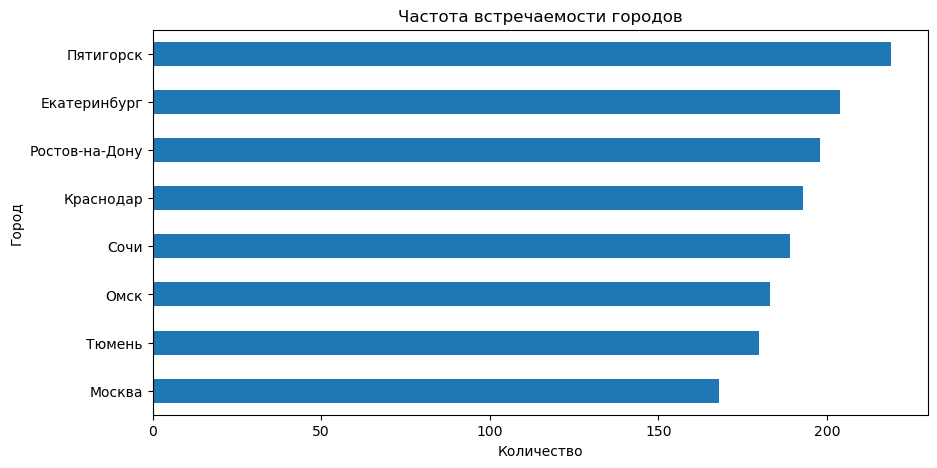

In [20]:
users_data['city'].value_counts(ascending=True).plot(kind='barh', figsize=(10, 5))

plt.title('Частота встречаемости городов')
plt.ylabel('Город')
plt.xlabel('Количество')
plt.show()

Как видно, чаще всего встречается Пятигорск (219), а реже всего - Москва (168). На втором и третьем месте - Екатеринбург (204) и Ростов-на-Дону (198).

### Соотношение пользователей с подпиской и без подписки

Посмотрим на соотношение пользователей с подпиской и без подписки в датасете `users_data`.

In [21]:
users_data['subscription_type'].value_counts()

subscription_type
free     835
ultra    699
Name: count, dtype: int64

Посмотрим на то же самое соотношение в процентах с помощью круговой диаграммы.

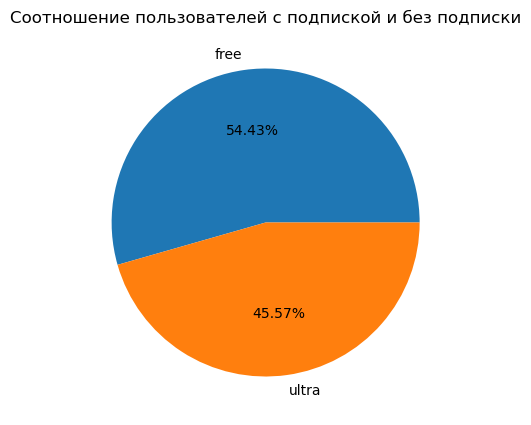

In [22]:
users_data['subscription_type'].value_counts(normalize=True).plot(kind='pie', figsize=(10, 5), autopct='%1.2f%%')

plt.title('Соотношение пользователей с подпиской и без подписки')
plt.ylabel('')
plt.show()

Как видно, пользователей без подписки больше - \~54.43% (835), чем с подпиской - \~45.57% (699). При этом разрыв не сильно большой. Получается у нас нет явного перекоса в сторону одного из типов подписок.
При этом бесплатных обычно должно быть больше, так как это обычно новые пользователи, которые ещё изучают сервис, прежде чем решаются на подписку или не так часто пользуются сервисом.
Я это проверю на этапе объединения данных.

### Возраст пользователей

Посмотрим на возраст пользователей в датасете `users_data`.

In [23]:
users_data['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Построим гистограмму, чтобы посмотреть на распределение возрастов.

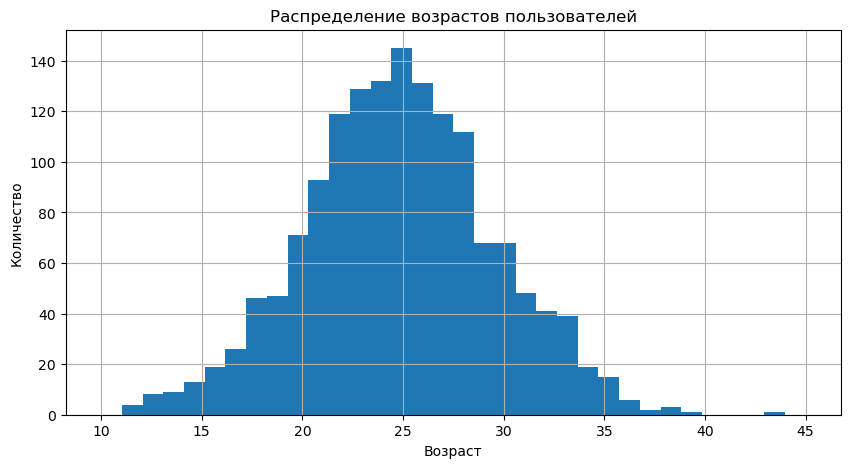

In [24]:
users_data['age'].hist(bins=np.histogram_bin_edges(users_data['age'], bins='auto', range=(10, 45)), figsize=(10, 5))

plt.title('Распределение возрастов пользователей')
plt.ylabel('Количество')
plt.xlabel('Возраст')
plt.show()

Как видно, большинство пользователей в возрасте от 20 до 30 лет. Средний возраст - \~25 лет, медиана - 25 лет. Получается, что в основном сервисом пользуются молодые люди.

### Расстояние, которое пользователь преодолел за одну поездку

Посмотрим на распределение расстояния, которое пользователь преодолел за одну поездку в датасете `rides_data`.

In [25]:
rides_data['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

Построим гистограмму, чтобы посмотреть на распределение расстояний.

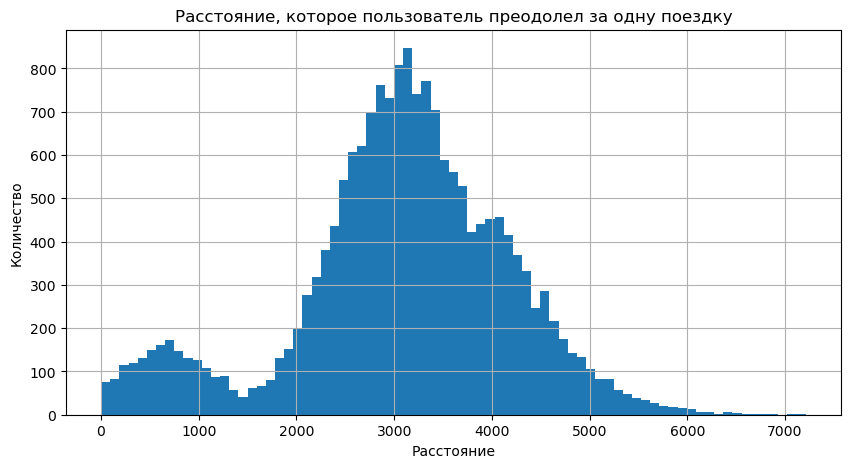

In [26]:
rides_data['distance'].hist(bins=np.histogram_bin_edges(rides_data['distance'], bins='auto'), figsize=(10, 5))

plt.title('Расстояние, которое пользователь преодолел за одну поездку')
plt.ylabel('Количество')
plt.xlabel('Расстояние')
plt.show()

Большинство данных находятся в диапазоне от 0 до 6000 метров, ограничу график по этому диапазону.

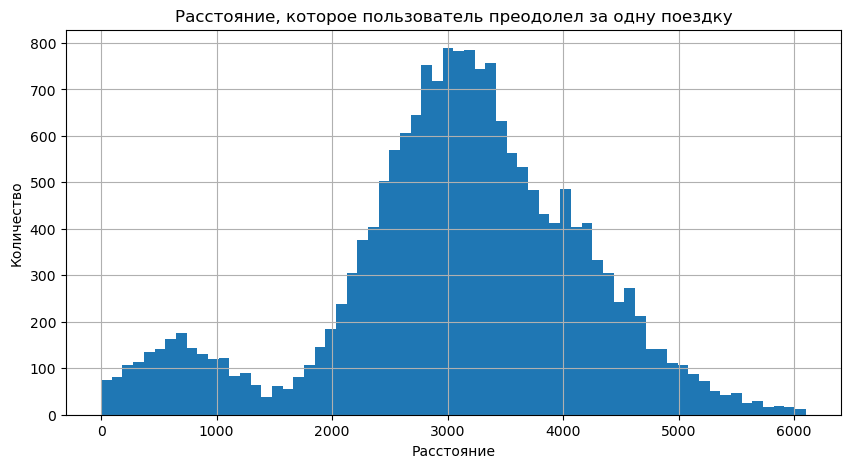

In [27]:
rides_data['distance'].hist(bins=np.histogram_bin_edges(rides_data['distance'], bins='auto', range=(0, 6100)), figsize=(10, 5))

plt.title('Расстояние, которое пользователь преодолел за одну поездку')
plt.ylabel('Количество')
plt.xlabel('Расстояние')
plt.show()

Построю график "Ящик с усами", чтобы посмотреть на выбросы.

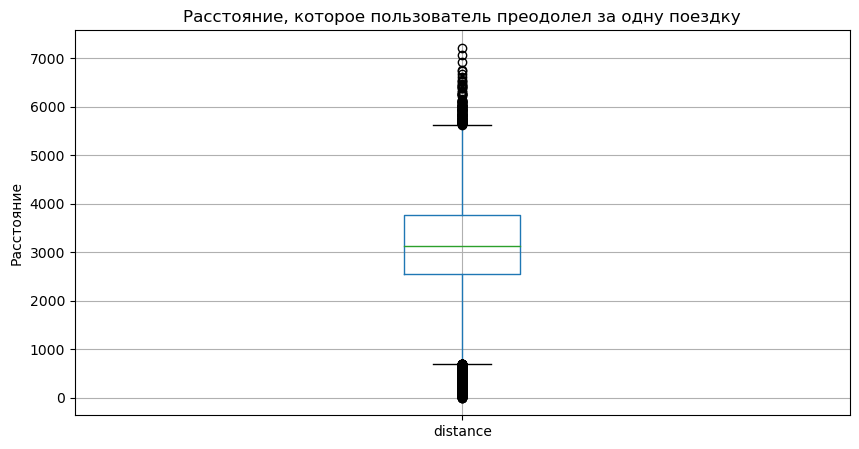

In [28]:
rides_data.boxplot('distance', figsize=(10, 5))

plt.title('Расстояние, которое пользователь преодолел за одну поездку')
plt.ylabel('Расстояние')
plt.show()

Данные для расстояния распределены нормально, с пиком в районе 3000 метров.
На графике "Ящик с усами" видно, что есть выбросы - данные до 1000 метров и после 5500 метров.
Есть небольшой пик в районе 500 метров и имеются данные около нуля - я думаю, что это не аномалия.
Скорее всего просто короткие поездки - это когда люди хотели развлечься или просто попробовать сервис.
А данные свыше 5500 метров - это скорее всего какие-то сверхдлинные поездки, которые тоже вполне могут быть реальными, так как люди могли гулять и из-за этого долго кататься на самокатах.

### Продолжительность поездок

Посмотрим на распределение продолжительности поездок в датасете `rides_data`.

In [29]:
rides_data['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

Построим гистограмму, чтобы посмотреть на распределение продолжительности поездок.

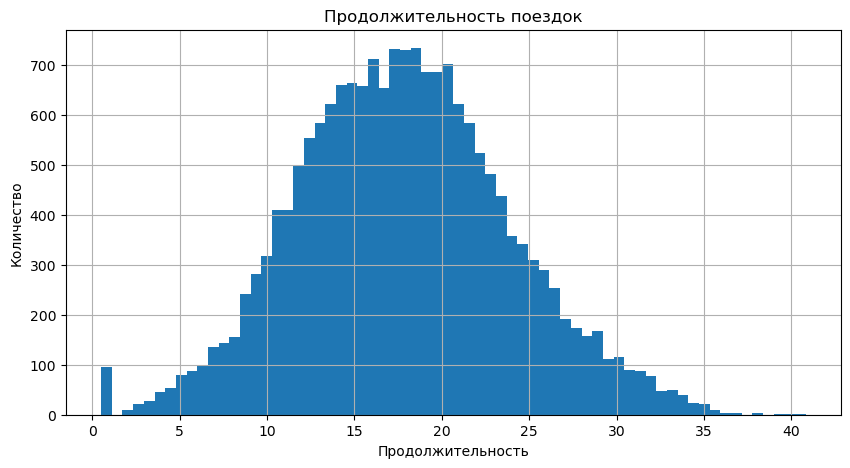

In [30]:
rides_data['duration'].hist(bins=np.histogram_bin_edges(rides_data['duration'], bins='auto'), figsize=(10, 5))

plt.title('Продолжительность поездок')
plt.ylabel('Количество')
plt.xlabel('Продолжительность')
plt.show()

Большинство данных находятся в диапазоне от 1 до 35 минут, ограничу график по этому диапазону.

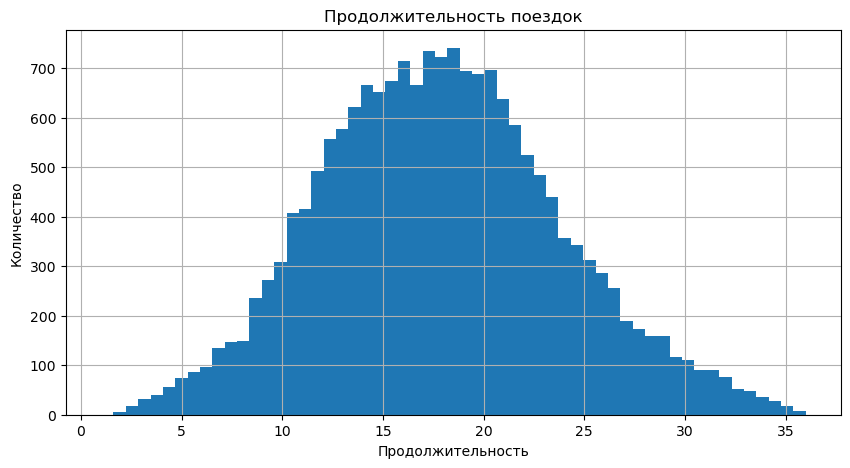

In [31]:
rides_data['duration'].hist(bins=np.histogram_bin_edges(rides_data['duration'], bins='auto', range=(1, 36)), figsize=(10, 5))

plt.title('Продолжительность поездок')
plt.ylabel('Количество')
plt.xlabel('Продолжительность')
plt.show()

Построю график “Ящик с усами”, чтобы посмотреть на выбросы.

<Axes: >

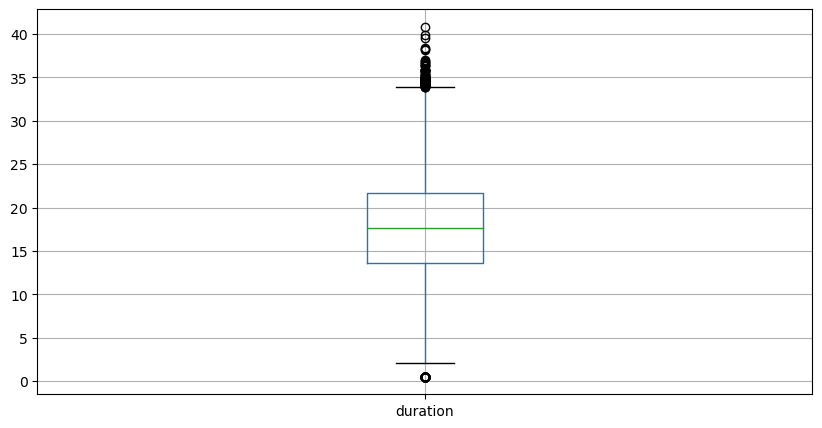

In [32]:
rides_data.boxplot('duration', figsize=(10, 5))

Данные для продолжительности поездок распределены нормально, с пиком в районе 17 минут.
На графике "Ящик с усами" видно, что есть выбросы - данные до примерно 1 минут и после 32 минут.
Выбросы до одной минуты - скорее всего когда люди оплатили самокат и резко передумали или случайно нажали на кнопку начала поездки.
Выбросы после 32 минут - опять же скорее всего относятся к длинным поездкам, которые могли быть связаны с прогулкой.

### Вывод по исследовательскому анализу данных
<a name="description-parameters-summary"></a>
По итогам исследовательского анализа данных были получены следующие результаты:
- Чаще всего встречается Пятигорск (219), а реже всего - Москва (168).
- Пользователей без подписки больше (835), чем с подпиской (699).
- Большинство пользователей в возрасте от 20 до 30 лет. Средний возраст - \~25 лет.
- Распределение расстояния, которое пользователь преодолел за одну поездку, нормальное, с пиком в районе 3000 метров.
- Распределение продолжительности поездок нормальное, с пиком в районе 17 минут.

## Объединение данных

Посмотрим на размеры датасетов перед объединением.

In [33]:
print('Размеры датафреймов:')
print(f"'user_data': {users_data.shape}\n'rides_data': {rides_data.shape}\n'subscriptions_data': {subscriptions_data.shape}")

Размеры датафреймов:
'user_data': (1534, 5)
'rides_data': (18068, 5)
'subscriptions_data': (2, 4)


Объединю данные о пользователях, поездках и подписках в один датафрейм.

In [34]:
data = rides_data.merge(users_data, on='user_id', how='left').merge(subscriptions_data, on='subscription_type', how='left')

Проверю размеры получившегося датафрейма.

In [35]:
print(f"Размер датафрейма 'data': {data.shape}")

Размер датафрейма 'data': (18068, 12)


Как мы видим, количество строк в датафрейме 'data' равно количеству строк в датафрейме 'rides_data'.

Так как я объединил датафреймы 'users_data' и 'rides_data' с помощью метода 'merge', где указал 'left', по ключу 'user_id', то размеры датафрейма 'data' должны быть равны размерам датафрейма 'rides_data'.
Датафрейм 'subscriptions_data' я уже объединил с получившимся датафреймом тем же способом по ключу 'subscription_type', поэтому размеры после этого не должны изменится.

Итоговое количество столбцов должно равняться сумме столбцов всех датафреймов, минус количество столбцов, которые я использовал для объединения, в нашем случае это 2 столбца - 'user_id' и 'subscription_type'.

Посмотрю на 10 случайных строк объединённого датафрейма.

In [36]:
data.sample(10)

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
2272,243,3523.680695,13.610038,2021-05-08,5,Владислава,30,Екатеринбург,ultra,6,0,199
3349,361,3489.150745,29.934904,2021-11-05,11,Анастасия,28,Краснодар,ultra,6,0,199
14022,1246,4012.703120,23.050812,2021-10-20,10,Максим,22,Тюмень,free,8,50,0
4653,501,4103.765788,36.622595,2021-05-24,5,Мария,34,Сочи,ultra,6,0,199
15456,1352,3892.708237,10.983173,2021-08-01,8,Евгения,30,Москва,free,8,50,0
6137,658,2851.557337,11.843738,2021-09-10,9,Даниил,25,Омск,ultra,6,0,199
17610,1503,3239.470175,17.478940,2021-09-16,9,Дмитрий,27,Пятигорск,free,8,50,0
3399,367,1255.738730,8.424742,2021-02-02,2,Владислава,29,Омск,ultra,6,0,199
10615,1000,2381.466642,10.103143,2021-10-27,10,Эльвира,29,Екатеринбург,free,8,50,0
11564,1069,3010.086231,12.600246,2021-05-13,5,Степан,20,Сочи,free,8,50,0


Посмотрю на общую информацию о данных объединённого датафрейма.

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   distance           18068 non-null  float64       
 2   duration           18068 non-null  float64       
 3   date               18068 non-null  datetime64[ns]
 4   month              18068 non-null  int32         
 5   name               18068 non-null  object        
 6   age                18068 non-null  int64         
 7   city               18068 non-null  object        
 8   subscription_type  18068 non-null  object        
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(5), object(3)
memory usage: 1.6+ MB


Теперь создам ещё два датафрейма из датафрейма `data`:
- с данными о пользователях без подписки;
- с данными о пользователях с подпиской.

In [38]:
data_free = data.query('subscription_type == "free"')
data_ultra = data.query('subscription_type == "ultra"')

Выведу первые 5 строк обоих датафреймов.

In [39]:
data_free.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
6500,700,2515.690719,14.944286,2021-01-02,1,Айдар,22,Омск,free,8,50,0
6501,700,846.932642,16.234663,2021-02-01,2,Айдар,22,Омск,free,8,50,0
6502,700,4004.434142,20.016628,2021-02-04,2,Айдар,22,Омск,free,8,50,0
6503,700,1205.911290,9.782872,2021-02-10,2,Айдар,22,Омск,free,8,50,0
6504,700,3047.379435,17.427673,2021-02-14,2,Айдар,22,Омск,free,8,50,0


In [40]:
data_ultra.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


Построю графики, чтобы визуализировать информацию о расстоянии и времени поездок для пользователей обеих категорий.

In [41]:
# Напишу функцию для построения гистограмм, чтобы не дублировать код

def plot_two_hists_by_column(data_first, data_second, column, label):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    data_first[column].hist(bins=np.histogram_bin_edges(data_first[column], bins='auto'), ax=ax[0])
    ax[0].set_title(f'{label} для пользователей без подписки')
    ax[0].set_ylabel('Количество')
    ax[0].set_xlabel(label)

    data_second[column].hist(bins=np.histogram_bin_edges(data_second[column], bins='auto'), ax=ax[1])
    ax[1].set_title(f'{label} для пользователей с подпиской')
    ax[1].set_ylabel('Количество')
    ax[1].set_xlabel(label)

    plt.show()

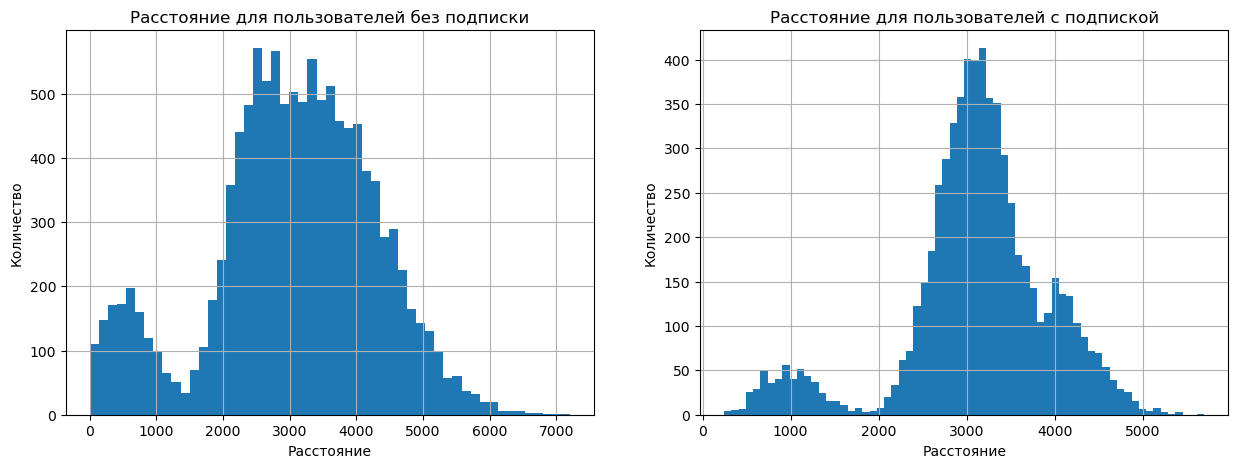

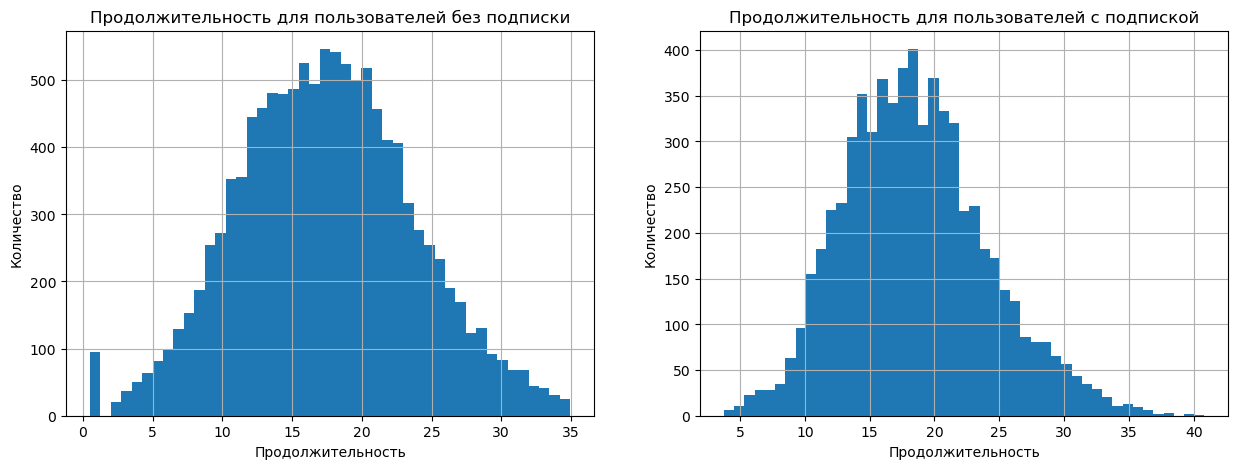

In [42]:
plot_two_hists_by_column(data_free, data_ultra, 'distance', 'Расстояние')

plot_two_hists_by_column(data_free, data_ultra, 'duration', 'Продолжительность')

### Вывод по объединению данных
<a name="union-data-summary"></a>
Данные были успешно объединены. Были созданы два датафрейма:
- с данными о пользователях без подписки;
- с данными о пользователях с подпиской.

**Сравнение графиков обеих групп пользователей:**

***Расстояние:***
- По графикам видно, что максимальное расстояние поездки для пользователей без подписки больше примерно на \~1 км.
- Максимальное количество в пиках у пользователей с подпиской меньше, примерно на 100, но это и не удивительно, так как пользователей без подписки меньше.
- Пики в обоих случаях \~3000 метров, то есть независимо от подписки пользователи обычно используют самокаты, чтобы проехать \~3 км.
- Распределения и там и там нормальное, но у пользователей с подпиской колокол уже. При этом на распределениях, есть несколько небольших пиков.
- Так у пользователей без подписки есть небольшой пик в районе 500 метров - скорее всего моменты, когда люди пробовали пользоваться самокатом и проезжали небольшие расстояния.
- У пользователей с подпиской же заметны небольшие пики в райне 1000 и 4000 метров - это, плюс то, что колокол в данном случае более узкий скорее всего говорит о том, что люди с подпиской чаще всего используют самокаты, чтобы преодолевать конкретные расстояния. То есть люди могут на них постоянно ездить на работу или учёбу.

***Продолжительность:***
- По максимальному времени на самокате пользователи похожи.
- Максимальное количество в пиках опять же больше у пользователей без подписки примерно на 100, что, как и упоминалось ранее, связано из-за того, что пользователей без подписки больше.
- Пики в обоих случаях опять же в районе 17 минут, — не удивительно, так как если в расстоянии пики примерно одинаковые, то и время тоже будет примерно одинаковое.
- Распределения опять же нормальное в обоих случаях и колокол в распределении пользователей с подписками уже.
- У пользователей с подписками видно, что некоторое время выделяется, на фоне остальных - это в промежутке от 14 до 20 минут. Тут опять же скорее всего это связано, как и в случае с расстоянием, что пользователи с подпиской скорее всего постоянно используют самокаты, чтобы преодолевать конкретные расстояния за определённое время - поехали на работу, учёбу и тому подобное.


## Подсчёт выручки

Создам датафрейм с агрегированными данными о поездках на основе датафрейма `data`: найду суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [43]:
revenue_data = (
    data.groupby(['user_id', 'month'])
    .agg({'user_id': 'size', 'distance': 'sum', 'duration': 'sum'})
    .rename(columns={'user_id': 'rides_count'})
    .reset_index()
)

Проверю есть ли пропуски в получившиеся сводной таблице.

In [44]:
revenue_data.isna().sum()

user_id        0
month          0
rides_count    0
distance       0
duration       0
dtype: int64

Посмотрю на первые 10 строк получившегося датафрейма.

In [45]:
revenue_data.head(10)

,user_id,month,rides_count,distance,duration
0,1,1,2,7027.511294,41.416640
1,1,4,1,754.159807,6.232113
2,1,8,2,6723.470560,44.776802
3,1,10,2,5809.911100,31.578017
4,1,11,3,7003.499363,53.397424
5,1,12,2,6751.629942,27.203912
6,2,3,3,10187.723006,60.959959
7,2,4,2,6164.381824,39.048633
8,2,6,1,3255.338202,13.851127
9,2,7,2,6780.722964,46.170157


Округлю значения в столбце `duration` в большую сторону до минуты, так как стоимость поездки считается за каждую минуту.

In [46]:
revenue_data['duration'] = np.ceil(revenue_data['duration'])

Добавлю столбец с помесячной выручкой, которую принёс каждый пользователь.

Для простоты расчётов создам отдельную переменную revenue_data_with_subs, где для каждого пользователя добавлю информацию о подписках и их стоимости.

In [47]:
revenue_data_with_subs = (revenue_data
                          .merge(users_data[['user_id', 'subscription_type']], on='user_id', how='left')
                          .merge(subscriptions_data, on='subscription_type', how='left')
                          )

Произведу необходимые расчёты по формуле:
- стоимость старта поездки * количество поездок + стоимость одной минуты поездки * общая продолжительность всех поездок в минутах + стоимость подписки.

In [48]:
revenue_data['revenue'] = (
        revenue_data_with_subs['rides_count'] * revenue_data_with_subs['start_ride_price'] +
        revenue_data_with_subs['duration'] * revenue_data_with_subs['minute_price'] +
        revenue_data_with_subs['subscription_fee']
)

Посмотрю на первые 10 строк получившегося датафрейма.

In [49]:
revenue_data.head(10)

,user_id,month,rides_count,distance,duration,revenue
0,1,1,2,7027.511294,42.0,451.0
1,1,4,1,754.159807,7.0,241.0
2,1,8,2,6723.470560,45.0,469.0
3,1,10,2,5809.911100,32.0,391.0
4,1,11,3,7003.499363,54.0,523.0
5,1,12,2,6751.629942,28.0,367.0
6,2,3,3,10187.723006,61.0,565.0
7,2,4,2,6164.381824,40.0,439.0
8,2,6,1,3255.338202,14.0,283.0
9,2,7,2,6780.722964,47.0,481.0


В `revenue_data_with_subs` также добавлю столбец с помесячной выручкой, которую принёс каждый пользователь.
В дальнейшем это будет удобно для проверки гипотез.

In [50]:
revenue_data_with_subs['revenue'] = (
        revenue_data_with_subs['rides_count'] * revenue_data_with_subs['start_ride_price'] +
        revenue_data_with_subs['duration'] * revenue_data_with_subs['minute_price'] +
        revenue_data_with_subs['subscription_fee']
)

### Вывод по подсчёту выручки
<a name="revenue-data-summary"></a>
Был создан датафрейм с агрегированными данными о поездках на основе датафрейма `data`. Для каждого пользователя были посчитаны:
- суммарное расстояние;
- количество поездок;
- суммарное время за каждый месяц.
- Добавлен столбец с помесячной выручкой, которую принёс каждый пользователь.

## Проверка гипотез

### Тратят ли пользователи с подпиской больше времени на поездки?

Сформулирую гипотезы:
- H0: Среднее время поездок пользователей с подпиской и без подписки одинаково.
- H1: Среднее время поездок пользователей с подпиской больше, чем у пользователей без подписки.

Уровень значимости возьму 0.05.
Проверю гипотезу с помощью t-теста для независимых выборок.

In [51]:
alpha = 0.05

results = stats.ttest_ind(data_free['duration'], data_ultra['duration'], alternative='less')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


По результатам t-теста я отвергаю нулевую гипотезу, даже если уровень значимости взять 0.01, то ничего не изменится.
Получается, скорее всего пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки.
Получается подписчики могут быть выгоднее для сервиса, но для подтверждения этого нам нужно будет проверить гипотезу о выручке.

### Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

Сформулирую гипотезы:
- H0: Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, равно 3130 метрам.
- H1: Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, превышает 3130 метр.

Уровень значимости возьму 0.05.
Проверю гипотезу с помощью одновыборочного t-теста.

In [52]:
alpha = 0.05

results = stats.ttest_1samp(data_ultra['distance'], 3130, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


По результатам t-теста я не могу отвергнуть нулевую гипотезу, так как p-значение значительно больше уровня значимости.
Получается, скорее всего среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, примерно равно 3130 метрам.
Соответственно подписчики не превышают оптимальное значение в 3130 метров и износ самокатов у них не сильно больше, чем у обычных пользователей.

### Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

Сформулирую гипотезы:
- H0: Помесячная выручка от пользователей с подпиской и пользователей без подписки одинакова.
- H1: Помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки.

Уровень значимости возьму 0.05.
Проверю гипотезу с помощью t-теста для независимых выборок.

In [53]:
revenue_data_with_subs_free = revenue_data_with_subs.query('subscription_type == "free"')
revenue_data_with_subs_ultra = revenue_data_with_subs.query('subscription_type == "ultra"')

alpha = 0.05

results = stats.ttest_ind(revenue_data_with_subs_free['revenue'], revenue_data_with_subs_ultra['revenue'], alternative='less')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 2.8130926188487286e-35
Отвергаем нулевую гипотезу


По результатам t-теста я отвергаю нулевую гипотезу, даже если уровень значимости взять 0.01, то ничего не изменится.
Получается, скорее всего помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки.
Получается подписчики действительно выгоднее для сервиса.

### Снизятся ли запросы в техническую поддержку, после обновления серверов?

Для проверки данной гипотезы мне бы понадобился парный t-тест, когда выборки зависимы. Я бы использовал метод `ttest_rel` из библиотеки `scipy.stats`.

Нулевую гипотезу можно было бы сформировать так: среднее количество запросов в техническую поддержку до обновления серверов равно среднему количеству запросов после обновления серверов.
Альтернативная гипотеза: среднее количество запросов в техническую поддержку после обновления серверов меньше, чем до обновления серверов.

### Вывод по проверке гипотез
<a name="hypothesis-summary"></a>
По результатам проверки гипотез:
- Пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки.
- Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, примерно равно 3130 метрам.
- Помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки.

Таким образом, подписчики действительно выгоднее для сервиса, чем обычные пользователи. Поэтому, возможно, стоит больше сосредоточиться на привлечении новых подписчиков и удержании старых.

## Распределения    

### Промокоды на один бесплатный месяц подписки

Посчитаю минимальное количество промокодов, которое нужно отправить, чтобы получить 100 успешных продлений подписки, при этом вероятность не выполнить план не должна превышать 5%.

Минимальное количество промокодов для отправки: 1172


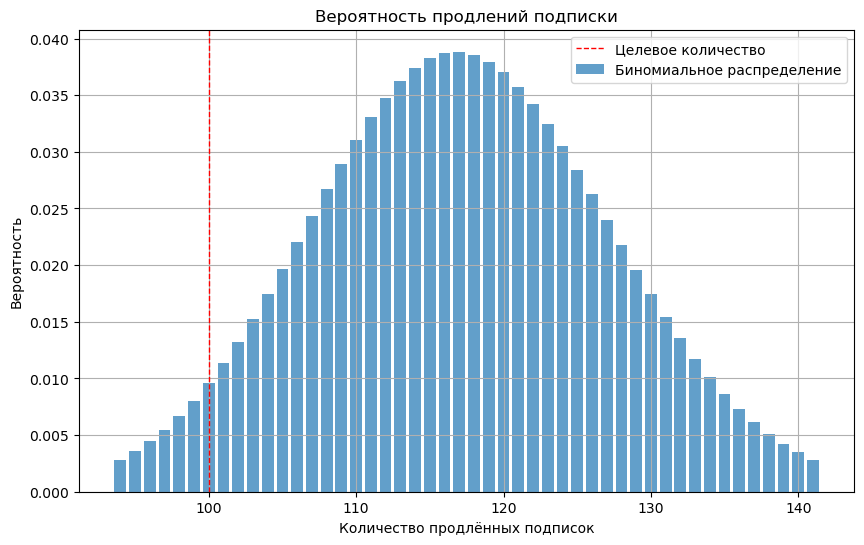

In [54]:
p_sub_renewal = 0.1  # Вероятность успеха
target_renewals = 100  # Целевое количество успехов
target_probability = 0.05  # Целевая вероятность

# Ищем минимальное количество промокодов для отправки
promo_codes = 1000  # Начнём с 1000 промокодов
while stats.binom(promo_codes, p_sub_renewal).cdf(target_renewals) > target_probability:
    promo_codes += 1 # Увеличиваем promo_codes, пока не достигнем целевой вероятности

print(f"Минимальное количество промокодов для отправки: {promo_codes}")

distr_renewal = stats.binom(promo_codes, p_sub_renewal)
subs_renewals = np.arange(distr_renewal.ppf(0.01), distr_renewal.ppf(0.99))

# Построим график биномиального распределения


plt.figure(figsize=(10, 6))

plt.bar(subs_renewals, distr_renewal.pmf(subs_renewals), align='center', alpha=0.7)

# Добавим вертикальную линию на целевое количество успешных продлений.
plt.axvline(target_renewals, color='r', linestyle='dashed', linewidth=1)

plt.legend(['Целевое количество', 'Биномиальное распределение'])

plt.grid(True)

plt.title('Вероятность продлений подписки')
plt.xlabel('Количество продлённых подписок')
plt.ylabel('Вероятность')

plt.show()

### Вывод по количеству промокодов на один бесплатный месяц подписки
<a name="promo-code-summary"></a>
Минимальное количество промокодов, которое нужно отправить, чтобы получить 100 успешных продлений подписки, при этом вероятность не выполнить план не должна превышать 5%, равно 1172.

Из графика мы видим, что при заданном количестве промокодов, мы можем получить от 100 до 140 успешных продлений подписки.
При этом пик у нас в райне 119-120 успешных продлений подписки.

### Push-уведомления в мобильном приложении

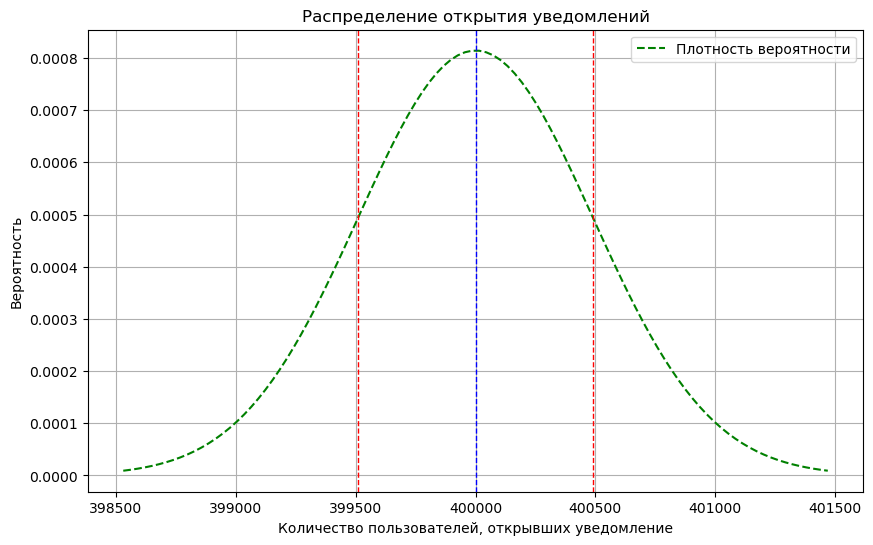

Вероятность того, что уведомление откроют не более 399 500 пользователей: 0.1537


In [55]:
notifications_sent = 1_000_000 # Количество отправленных уведомлений
prob_opens = 0.4  # Вероятность открытия уведомления

# Рассчитаем среднее и стандартное отклонение
mu = notifications_sent * prob_opens
sigma = np.sqrt(notifications_sent * prob_opens * (1 - prob_opens))
distr = stats.norm(mu, sigma)

# Зададим x и y для графика
x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 100)
y = distr.pdf(x)

plt.figure(figsize=(10, 6))

plt.plot(x, y, 'g--', label='Плотность вероятности')

plt.grid(True)

# Добавим вертикальные линии для среднего и стандартного отклонения, чтобы было нагляднее
plt.axvline(mu, color='blue', linestyle='dashed', linewidth=1)
plt.axvline(mu - sigma, color='red', linestyle='dashed', linewidth=1)
plt.axvline(mu + sigma, color='red', linestyle='dashed', linewidth=1)

plt.title('Распределение открытия уведомлений')
plt.xlabel('Количество пользователей, открывших уведомление')
plt.ylabel('Вероятность')

plt.legend()

plt.show()

prob = distr.cdf(399500)
print(f'Вероятность того, что уведомление откроют не более 399 500 пользователей: {prob:.4f}')

### Вывод по push-уведомлениям в мобильном приложении
<a name="push-mobile-app-summary"></a>
Вероятность того, что уведомление откроют не более 399 500 пользователей: \~15.37%.
Математическое ожидание равно 400 000, а стандартное отклонение равно 500.

## Общий вывод

В ходе выполнения проекта изначально были предобработаны данные:
- Приведены столбцы date к типу даты pandas.
- Создан новый столбец с номером месяца на основе столбца date.
- Удалены явные дубликаты.

Отмечу, что данные, в целом, в хорошем состоянии, не было пропусков, только немного явных дубликатов.
[Подробнее в выводе о предобработке данных](#preprocessing-data-summary)

Далее были изучены и описаны параметры:
- Частота встречаемости городов;
- Соотношение пользователей с подпиской и без подписки;
- Возраст пользователей;
- Расстояние, которое пользователь преодолел за одну поездку;
- Продолжительность поездок.
[Подробнее в выводе об исследовательском анализе данных](#description-parameters-summary)

Затем объединены данные о пользователях, поездках и подписках в один датафрейм. Были созданы два датафрейма:
- С данными о пользователях без подписки.
- С данными о пользователях с подпиской.
- Визуализирована информация о расстоянии и времени поездок для пользователей обеих категорий.
- Получившиеся графики были изучены и описаны.
[Подробнее в выводе об объединении данных](#union-data-summary)

После я подсчитал выручку:
- Создал датафрейм с агрегированными данными о поездках на основе датафрейма `data`.
- Для каждого пользователя посчитал:
    - Суммарное расстояние;
    - Количество поездок;
    - Суммарное время за каждый месяц.
- Добавил столбец с помесячной выручкой, которую принёс каждый пользователь.
[Подробнее в выводе о подсчёте выручки](#revenue-data-summary)

После я проверил и сделал выводы по следующим гипотезам:
- Пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки.
- Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, примерно равно 3130 метрам.
- Помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки.
[Подробнее в выводе о проверке гипотез](#hypothesis-summary)

Также я посчитал минимальное количество промокодов, которое нужно отправить, чтобы получить 100 успешных продлений подписки: 1172 промокода.
[Подробнее в выводе о промокодах на один бесплатный месяц подписки](#promo-code-summary).

И рассчитал вероятность того, что уведомление откроют не более 399 500 пользователей: \~15.37%.
[Подробнее в выводе о push-уведомлениях в мобильном приложении](#push-mobile-app-summary)

В целом, по итогам исследования можно сделать следующие выводы:
- Подписчики действительно выгоднее для сервиса, чем обычные пользователи.
- Стоит больше сосредоточиться на привлечении новых подписчиков и удержании старых.
- Полученные результаты по промокодам смогут помочь отделу маркетинга привлекать новых подписчиков, так что на них стоит обратить внимание.
- Ещё я думаю, что нужно подумать как улучшить push-уведомления, чтобы увеличить вероятность открытия уведомлений, так как сейчас она не такая большая. Если больше подписчиков будет открывать релевантные для них уведомления, то это может помочь удержать их.
- Также не стоит беспокоиться о сильном износе самокатов со стороны подписчиков, так как они не превышают оптимальное значение в 3130 метров.